In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles

In [3]:
random_seed = 123
N = 100
K = 5
colors = ["#FF4500", "#228B22", "#FFA500", "#32CD32"]

In [4]:
# Generate drifted dataset

X, Y = make_blobs(n_samples=N*4, n_features=2, centers=[[-2,-2],[3,3],[0,-1],[4,5]], cluster_std=2, random_state=random_seed)

source_idx0 = Y == 0
source_idx1 = Y == 1
target_idx0 = Y == 2
target_idx1 = Y == 3

X_source = X[source_idx0 | source_idx1]
X_target = X[target_idx0 | target_idx1]

y_source = Y[source_idx0 | source_idx1]
y_target = Y[target_idx0 | target_idx1] - 2

print(X_source.shape, X_target.shape, y_source.shape, y_target.shape)

(200, 2) (200, 2) (200,) (200,)


In [6]:
# Select target data to label
from sklearn.model_selection import train_test_split

X_target_labeled, X_target_unlabeled, y_target_labeled, y_target_unlabeled = train_test_split(X_target, y_target, train_size=K/N, random_state=random_seed)

print(X_target_labeled.shape, X_target_unlabeled.shape, y_target_labeled.shape, y_target_unlabeled.shape)

(10, 2) (190, 2) (10,) (190,)


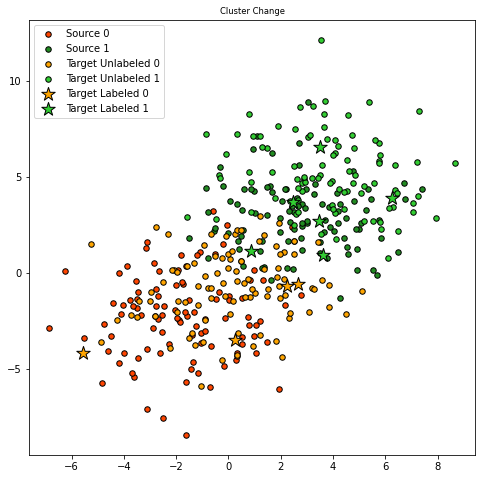

In [12]:
plt.figure(figsize=(8, 8))
plt.title("Cluster Change", fontsize="small")

s0 = plt.scatter(X_source[y_source==0][:, 0], X_source[y_source==0][:, 1], marker='o', c=colors[0], s=30, edgecolor='k')
s1 = plt.scatter(X_source[y_source==1][:, 0], X_source[y_source==1][:, 1], marker='o', c=colors[1], s=30, edgecolor='k')
s2 = plt.scatter(X_target_unlabeled[y_target_unlabeled==0][:, 0], X_target_unlabeled[y_target_unlabeled==0][:, 1], marker='o', c=colors[2], s=30, edgecolor='k')
s3 = plt.scatter(X_target_unlabeled[y_target_unlabeled==1][:, 0], X_target_unlabeled[y_target_unlabeled==1][:, 1], marker='o', c=colors[3], s=30, edgecolor='k')
s4 = plt.scatter(X_target_labeled[y_target_labeled==0][:, 0], X_target_labeled[y_target_labeled==0][:, 1], marker='*', c=colors[2], s=200, edgecolor='k')
s5 = plt.scatter(X_target_labeled[y_target_labeled==1][:, 0], X_target_labeled[y_target_labeled==1][:, 1], marker='*', c=colors[3], s=200, edgecolor='k')
plt.legend((s0, s1, s2, s3, s4, s5), ("Source 0", "Source 1", "Target Unlabeled 0", "Target Unlabeled 1", "Target Labeled 0", "Target Labeled 1"))

plt.show()

In [24]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import numpy as np

torch.set_num_threads(32)
torch.manual_seed(random_seed)

In [27]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ToyModel(nn.Module):
    def __init__(self, inc=2, cls=2):
        super(ToyModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(inc, 3),
            nn.ReLU(),
            nn.Linear(3, cls)
        )

    def forward(self, x):
        return self.classifier(x)

In [41]:
# Test the model

def test(model, loader, tag="Test"):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    overall_loss = 0
    is_correct = []
    with torch.no_grad():
        for data in loader:
            X, y = data
            y_pred = model(X.float())
            loss = criterion(y_pred, y.long())
            probs = F.softmax(y_pred, dim=-1)
            _, predvals = torch.max(probs, 1)
            is_correct.extend((predvals == y).cpu().data.numpy())
            overall_loss += loss.item() / len(loader)
    accuracy = np.mean(np.array(is_correct, dtype=np.int64))
    print(f"[{tag}] loss: {overall_loss}, accuracy: {accuracy}")
    return overall_loss, accuracy

In [45]:
# Train the model

def train(train_loader, valid_loader, test_loader, epochs=100000, log_interval=100, early_stop=10):
    model = ToyModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    losses = []
    best_valid_acc = 0
    best_test_acc = 0
    counter = 0
    for i in range(epochs):
        model.train()
        for data in train_loader:
            X, y = data
            y_pred = model(X.float())
            loss = criterion(y_pred, y.long())
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if i % log_interval == 0:
            print(f"[Train] epoch {i}, loss: {loss.item()}, last {log_interval} averaged loss: {np.mean(losses)}")
            test(model, valid_loader, tag="Train")
            _, valid_acc = test(model, valid_loader, tag="Valid")
            _, test_acc = test(model, test_loader, tag="Test")
            losses = []

            if valid_acc > best_valid_acc:
                counter = 0
                best_valid_acc = valid_acc
                best_test_acc = test_acc
            else:
                counter += 1

            if counter > early_stop:
                print("Early stop!")
                break

In [46]:


train_dataset = ToyDataset(np.concatenate((X_source, X_target_labeled[:K]), axis=0), np.concatenate((y_source, y_target_labeled[:K]), axis=0))
valid_dataset = ToyDataset(X_target_labeled[K:], y_target_labeled[K:])
test_dataset = ToyDataset(X_target_unlabeled, y_target_unlabeled)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

train(train_loader, valid_loader, test_loader)

[Train] epoch 0, loss: 1.179797649383545, last 100 averaged loss: 1.179797649383545
[Train] loss: 1.5746958255767822, accuracy: 0.2
[Valid] loss: 1.5746958255767822, accuracy: 0.2
[Test] loss: 1.1589902639389038, accuracy: 0.43157894736842106
[Train] epoch 100, loss: 0.13107244670391083, last 100 averaged loss: 0.40160082906484607
[Train] loss: 0.1374426633119583, accuracy: 1.0
[Valid] loss: 0.1374426633119583, accuracy: 1.0
[Test] loss: 0.315182626247406, accuracy: 0.8578947368421053
[Train] epoch 200, loss: 0.11421562731266022, last 100 averaged loss: 0.11898865543305874
[Train] loss: 0.1631864309310913, accuracy: 1.0
[Valid] loss: 0.1631864309310913, accuracy: 1.0
[Test] loss: 0.3361143469810486, accuracy: 0.8526315789473684
[Train] epoch 300, loss: 0.11100197583436966, last 100 averaged loss: 0.1123720370978117
[Train] loss: 0.16412325203418732, accuracy: 1.0
[Valid] loss: 0.16412325203418732, accuracy: 1.0
[Test] loss: 0.33841672539711, accuracy: 0.8578947368421053
[Train] epoch 4

In [ ]:
import pytorch_influence_functions as ptif

ptif.init_logging()
config = ptif.get_default_config()

influences, harmful, helpful = ptif.calc_img_wise(config, model, train_loader, _loader)

In [ ]:
# Plot decision boundary

def plot_decision_boundary(pred_func,X,y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)